In [12]:
# Kernel -> py311ml
# imports aqui ->
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


Primeramente vamos a leer el archivo y comprobar las variables, con sus tipos de dato

In [13]:
data = pd.read_csv('src/adult.data', header=None, sep=',\s', na_values=["?"], engine='python')
data.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']


def check_df(dataframe, head=5):
    print("------------ Shape ------------")
    print(dataframe.shape)
    print("------------ Types ------------")
    print(dataframe.dtypes)
    
check_df(data)

------------ Shape ------------
(32561, 15)
------------ Types ------------
age                int64
workclass         object
final-weight       int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


Comprobamos que variables contienen valores perdidos 

In [14]:
data.isnull().sum()

age                  0
workclass         1836
final-weight         0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Ahora con ayuda de graficas, visualizamos la distribucion de las variables anteriores


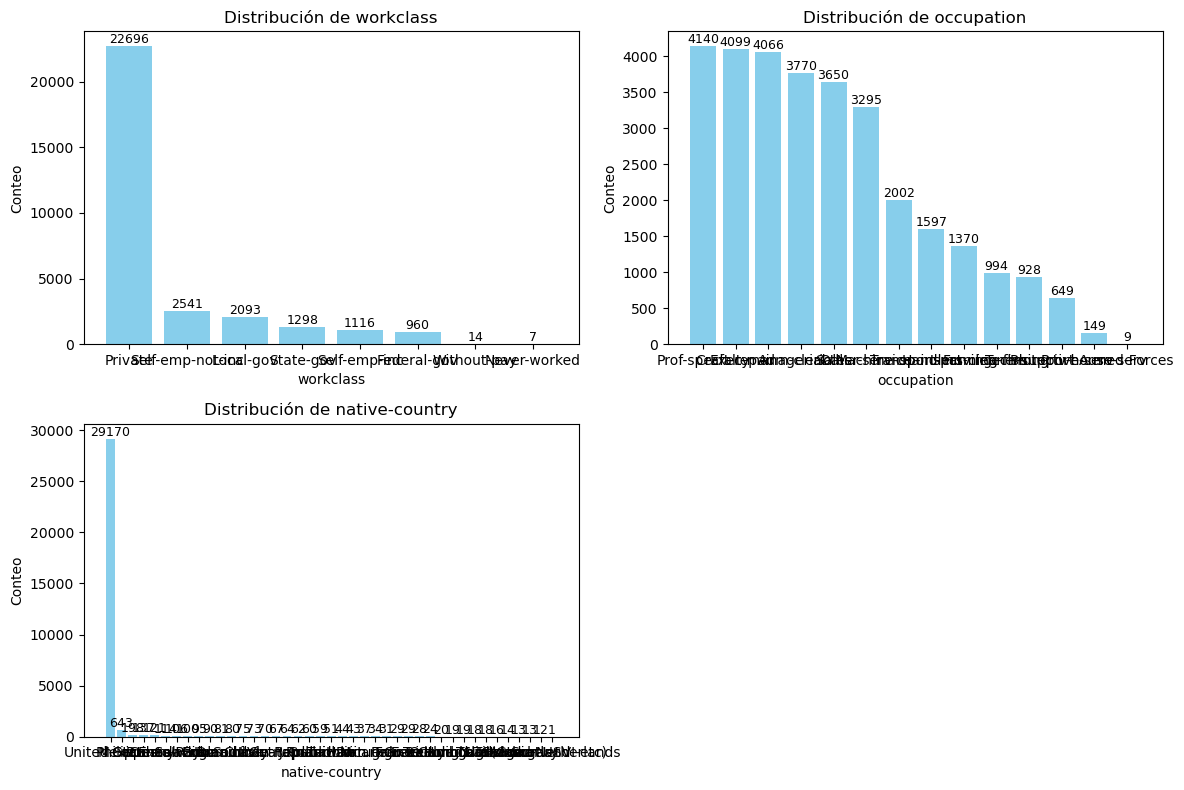

In [15]:

def check_col_plt(df, columns):
    num_plots = len(columns)
    # Definimos el número de filas y columnas del grid. En este ejemplo usamos 2x2.
    rows, cols = 2, 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()  # Aplanamos la matriz de ejes para iterar fácilmente

    for i, col in enumerate(columns):
        ax = axes[i]
        # Obtenemos la cuenta de cada valor único en la columna
        count_data = df[col].value_counts().reset_index()
        count_data.columns = [col, 'count']

        # Creamos el gráfico de barras
        bars = ax.bar(count_data[col].astype(str), count_data['count'], color='skyblue')
        ax.set_title(f"Distribución de {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Conteo")

        # Añadimos las etiquetas de conteo encima de cada barra
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

    # Eliminamos los ejes sobrantes si hay menos plots que subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
ncolumns = ["workclass", "occupation", "native-country"]
check_col_plt(data, ncolumns)


 decidir que hacer con los valores perdidos (mas adelante creo)

In [16]:
columnas_con_nulos = data.columns[data.isnull().any()].tolist()
print(columnas_con_nulos)

def rellenarModa(data, columna):
    dataCopiada = data.copy()
    moda = dataCopiada.loc[:, columna].mode()[0]
    dataCopiada[columna] = dataCopiada[columna].fillna(moda)
    return dataCopiada

dataRellena = rellenarModa(data, columnas_con_nulos[0])
dataRellena = rellenarModa(data, columnas_con_nulos[2])
print(dataRellena.iloc[27,: ])
data.loc[:, "occupation"]

['workclass', 'occupation', 'native-country']
age                               54
workclass                        NaN
final-weight                  180211
education               Some-college
education-num                     10
marital-status    Married-civ-spouse
occupation                       NaN
relationship                 Husband
race              Asian-Pac-Islander
sex                             Male
capital-gain                       0
capital-loss                       0
hours-per-week                    60
native-country                 South
income                          >50K
Name: 27, dtype: object


0             Adm-clerical
1          Exec-managerial
2        Handlers-cleaners
3        Handlers-cleaners
4           Prof-specialty
               ...        
32556         Tech-support
32557    Machine-op-inspct
32558         Adm-clerical
32559         Adm-clerical
32560      Exec-managerial
Name: occupation, Length: 32561, dtype: object

Pipeline

In [17]:

#Con trasformacion para occupation 
from sklearn.compose import ColumnTransformer


def transformar_income(X): 
    """Transforma la columna 'income' en una variable binaria."""

    X = X.copy()
    X['income'] = X['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    return X

def separar_x_y(data):
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y
def separar_x_y_col(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    return X, y

def transformar_categoricas_a_binarias(X): 

    X = X.copy()
    variables_categoricas_binarias = X.select_dtypes(include=['object']).columns
    dummies = pd.get_dummies(X, columns=variables_categoricas_binarias)
    if hasattr(transformar_categoricas_a_binarias, 'dummy_columns'):
        dummies = dummies.reindex(columns=transformar_categoricas_a_binarias.dummy_columns, fill_value=0)
    else:
        transformar_categoricas_a_binarias.dummy_columns = dummies.columns
    return dummies

def knnImp(X, y):
    y = y.copy()
    indicesNulos = np.where(y == -1)[0] 
    indicesNoNulos = np.where(y != -1)[0] 
    X_train = X.iloc[indicesNoNulos]
    X_test = X.iloc[indicesNulos]
    y_train = y[indicesNoNulos]

    
    knn = KNeighborsClassifier(n_neighbors= 3)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    y[indicesNulos] = pred
    return y


binary_transformer = FunctionTransformer(transformar_categoricas_a_binarias)

columnas_con_nulos = data.columns[data.isnull().any()].tolist()
dataRellena = rellenarModa(data, columnas_con_nulos[0])
dataRellena = rellenarModa(data, columnas_con_nulos[2])
data_binary_income = transformar_income(dataRellena)
X, y = separar_x_y(data_binary_income)
X, occupation = separar_x_y_col(X, "occupation")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

X_transformed = binary_transformer.transform(X)
occupationNombre = occupation.copy()
valoresOccupation = occupationNombre.dropna()
colConNulos = pd.Categorical(occupation, ordered= True).codes #Paso la variable a ordinal 

occupation_ord = knnImp(X_transformed, colConNulos) #Imputo los valores
occupation_series = pd.Series(occupation_ord)
occupation_mapeados = occupation_series.map(lambda x: occupationNombre[x])

occupationOHE = pd.get_dummies(occupation_mapeados)
X_transformed = pd.concat([X_transformed, occupationOHE], axis = 1) #Todas las columnas sin nulos y en OHE



preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numeric_features), mejora un 10% el auc , lo ponemos luego
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Definimos el pipeline con el transformador
pipeline = Pipeline([
    # ('transformar_categoricas', binary_transformer),
    ('preprocesador', preprocessor),
    ('classifier', KNeighborsClassifier())
])




In [18]:

from sklearn.compose import ColumnTransformer


def transformar_income(X): 
    """Transforma la columna 'income' en una variable binaria."""

    X = X.copy()
    X['income'] = X['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    return X

def separar_x_y(data):
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

def transformar_categoricas_a_binarias(X): 

    X = X.copy()
    variables_categoricas_binarias = X.select_dtypes(include=['object']).columns
    dummies = pd.get_dummies(X, columns=variables_categoricas_binarias)
    if hasattr(transformar_categoricas_a_binarias, 'dummy_columns'):
        dummies = dummies.reindex(columns=transformar_categoricas_a_binarias.dummy_columns, fill_value=0)
    else:
        transformar_categoricas_a_binarias.dummy_columns = dummies.columns
    return dummies
binary_transformer = FunctionTransformer(transformar_categoricas_a_binarias)


data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numeric_features), mejora un 10% el auc , lo ponemos luego
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Definimos el pipeline con el transformador
pipeline = Pipeline([
    # ('transformar_categoricas', binary_transformer),
    ('preprocesador', preprocessor),
    ('classifier', KNeighborsClassifier())
])

 


Una vez pasadas todas las variables a numericas, podemos ver la matriz de corelacion 

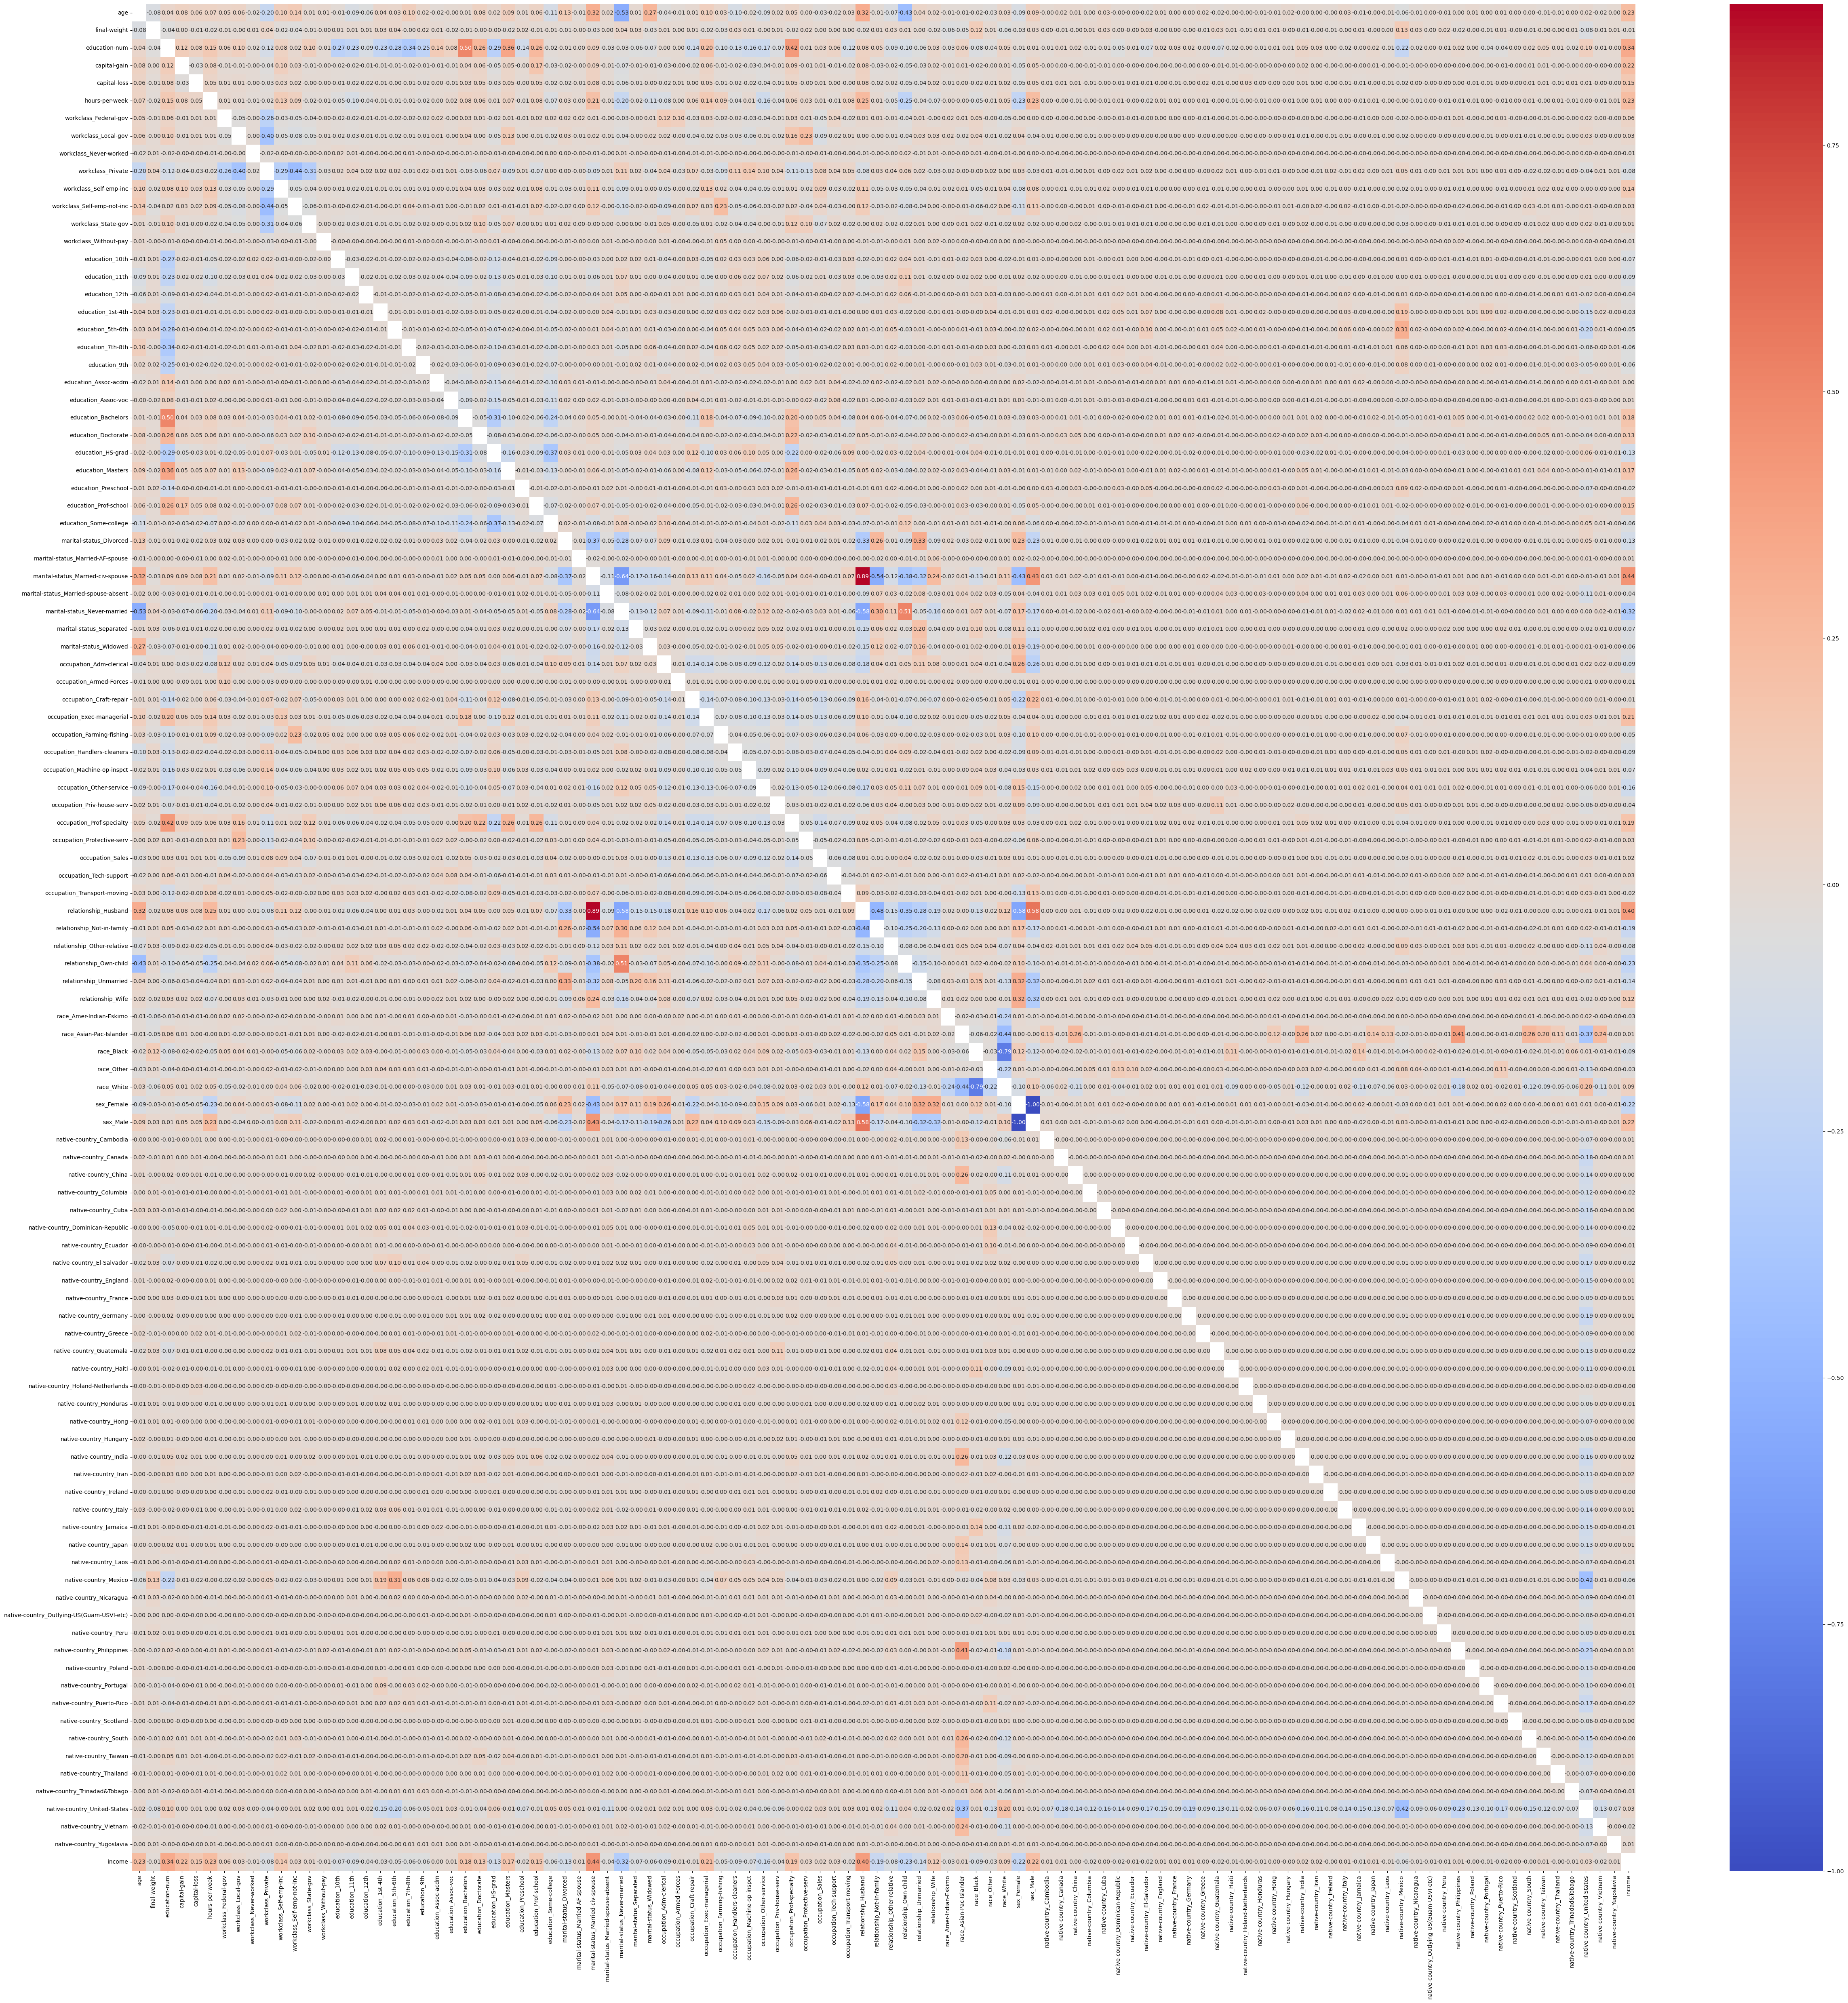

In [19]:
X_transformed = binary_transformer.transform(X)
X_transformed = pd.concat([X_transformed, y], axis=1)
corr_matrix = X_transformed.corr()
filtered_corr = corr_matrix.where(corr_matrix != 1)

plt.figure(figsize=(60,60))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Se observan varias correlaciones, algunas obvias como marital-status_Married-civ-spouse con relationship_husband y otras que vamos a analizar. Primero vamos a ver las mas influyentes en el propio resultado
 

In [20]:
correlations = X_transformed.corr()['income'].sort_values(ascending=False)
correlations = abs(correlations).sort_values(ascending=False)
correlations = correlations.drop('relationship_Husband') 
correlations = correlations.drop('sex_Male')
correlations = correlations.drop('sex_Female')


print("Most influential factors:\n", correlations[:6])

Most influential factors:
 income                               1.000000
marital-status_Married-civ-spouse    0.444696
education-num                        0.335154
marital-status_Never-married         0.318440
age                                  0.234037
hours-per-week                       0.229689
Name: income, dtype: float64


Probamos el rendimiento de nuetro modelo con la metrica seleccionada 

In [21]:
# print(X)
pipeline.fit(X, y)
predicciones = pipeline.predict(X)

In [22]:
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, predicciones)) 

Accuracy: 0.8275237247013298
Confusion Matrix:
 [[22850  1870]
 [ 3746  4095]]
AUC: 0.7233037826229977


Probamos el rendimiento de nuestro modelo con el test.data que previamente esta dividio por|1x3 Cross validator

In [ ]:
#Quitamos el punto final
def transformar_income_test(X): 
    X = X.copy()
    X['income'] = X['income'].str.strip().str.rstrip('.')
    X['income'] = X['income'].map({'<=50K': 0, '>50K': 1})
    return X

data_test = pd.read_csv('src/adult.test', header=None, skiprows=1, sep=',\s', na_values=["?"], engine='python')
data_test.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                     'hours-per-week', 'native-country', 'income']

data_test = transformar_income_test(data_test)
X_test, y_test = separar_x_y(data_test)
X_test_transformed = binary_transformer.transform(X_test)

#Predecimos los valores con el conjunto del test
predicciones_test = pipeline.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, predicciones_test))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, predicciones_test))
print("Test AUC:", roc_auc_score(y_test, predicciones_test))



Test Accuracy: 0.8109452736318408
Test Confusion Matrix:
 [[11362  1073]
 [ 2005  1841]]
Test AUC: 0.6961952229597025
